In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)

### 1. Read all CEO sample files
download your CEO sample files from collect.earth and upload to SEPAL using FileZilla.
add as many files as you have projects

In [3]:
ceo1 = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_all_ceo_1522_clean.csv',low_memory=False)
ceo2 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_all_ceo_1522_clean.csv',low_memory=False)
ceo3 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_all_ceo_1522_1622_clean.csv',low_memory=False)
ceo4 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_all_ceo_1522_clean.csv',low_memory=False)
ceo5 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_all_ceo_2015_2023_clean.csv',low_memory=False)
ceo6 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_all_ceo_1522_clean.csv',low_memory=False)

In [32]:
output_drivers = '/home/sepal-user/module_results/esbae/EQG/EQG_all_ceo_drivers.csv'

In [4]:
# Concatenate DataFrames
combined_ceo = pd.concat([ceo1, ceo2, ceo3, ceo4, ceo5, ceo6], axis=0, ignore_index=True)

In [5]:
len(combined_ceo)

41201

In [6]:
pd.pivot_table(combined_ceo,values='point_id',index=['ISO'],columns=['Ref_FNF_2015'],aggfunc="count",margins=True,
                             margins_name='Total')

Ref_FNF_2015,0.0,1.0,Total
ISO,,,
CAF,2764,1613,4377
CMR,3485,3248,6733
COD,6297,6850,13147
COG,143,260,403
EQG,878,3604,4482
GAB,1366,7007,8373
Total,14933,22582,37515


In [7]:
print(combined_ceo.dtypes)

ID                        float64
plotid                    float64
sampleid                  float64
lon                       float64
lat                       float64
sample_geom                object
point_id                  float64
Ref_FNF_2015              float64
Ref_Regeneration           object
Ref_Change_1522           float64
Ref_Change_Type_1522       object
ArtFor                    float64
ArtMine                   float64
InfraR                    float64
Urb                       float64
IndFor                    float64
Other                     float64
Other_Desc                 object
IndMine                   float64
IndAg                     float64
ArtAg                     float64
Ref_Year_1522             float64
Ref_NFtype                float64
Ref_Ftype                 float64
collection                 object
interpreted               float64
Ref_LCover                float64
Ref_Change_Year_1522       object
Def2016                   float64
Def2017       

In [11]:
combined_ceo['CountDrivers'] = combined_ceo[['ArtFor','ArtMine',
                                             'InfraR','Urb','IndFor','Other',
                                             'IndMine','IndAg','ArtAg']].sum(axis=1)

In [14]:
combined_ceo['IndDrivers'] = (combined_ceo['IndAg'] == 1) | (combined_ceo['IndFor'] == 1) | (combined_ceo['IndMine'] == 1)
combined_ceo['IndDrivers'].value_counts(dropna=False)

IndDrivers
False    40979
True       222
Name: count, dtype: int64

In [15]:
# Function to determine 'GroupedDrivers'
def determine_grouped_drivers(row):
    if row['CountDrivers'] == 0:
        return ""
    elif row['ArtMine'] == 1 and row['IndDrivers'] == "False":
        return "artisanal mining"
    elif row['ArtMine'] == 1 and row['CountDrivers'] <= 2:
        return "artisanal mining"
    elif row['IndMine'] == 1:
        return "industrial mining"
    elif row['IndAg'] == 1 and row['IndFor'] == 1 and row['IndMine'] == 0:
        return "industrial forestry and agriculture"
    elif row['IndFor'] == 1 and row['IndAg'] == 0 and row['IndMine'] == 0:
        return "industrial forestry"
    elif row['IndAg'] == 1 and row['IndFor'] == 0 and row['IndMine'] == 0:
        return "industrial agriculture"
    elif row['ArtFor'] == 1 and row['ArtAg'] == 0 and row['ArtMine'] == 0 and row['IndDrivers'] == "False":
        return "artisanal forestry"
    elif row['ArtAg'] == 1 and row['InfraR'] == 1 and row['CountDrivers'] <= 2 and row['ArtMine'] == 0:
        return "infrastructure agriculture"
    elif row['CountDrivers'] <= 2 and row['ArtAg'] == 0 and (row['InfraR'] == 1 or row['Urb'] == 1) and row['IndDrivers'] == "False":
        return "human infrastructure"
    elif row['ArtFor'] == 1 and row['CountDrivers'] == 1:
        return "artisanal forestry"
    elif row['CountDrivers'] == 1 and row['Other'] == 1:
        return "other"
    else:
        return "rural complex"

# Apply the function to create the new column
combined_ceo['GroupedDrivers'] = combined_ceo.apply(determine_grouped_drivers, axis=1)

In [16]:
combined_ceo['GroupedDrivers'].value_counts(dropna=False)

GroupedDrivers
                                       38905
rural complex                           1763
artisanal forestry                       207
industrial forestry                      127
industrial agriculture                    71
infrastructure agriculture                47
other                                     44
industrial mining                         21
artisanal mining                          13
industrial forestry and agriculture        3
Name: count, dtype: int64

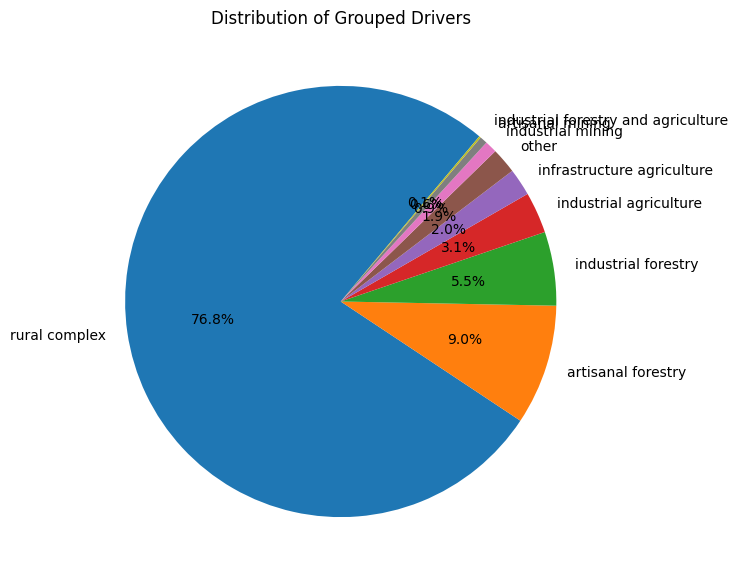

In [27]:
# Filter out blank values
filtered_df = combined_ceo[combined_ceo['GroupedDrivers'] != '']

# Count the occurrences of each value
grouped_counts = filtered_df['GroupedDrivers'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(grouped_counts, labels=grouped_counts.index, autopct='%1.1f%%', startangle=50)

# Add a title
plt.title('Distribution of Grouped Drivers')

# Show the plot
plt.show()

In [30]:
# select columns to extract
columns_to_extract = ['Ref_FNF_2015','Ref_Regeneration','Ref_Change_Year',
'Ref_Change_Type','Ref_LCover_combined','Combined_Ref_FNF','Ref_NFtype','Ref_Ftype','ArtFor','ArtMine','InfraR','Urb',
'IndFor','IndMine','IndAg','ArtAg','Other','Other_Desc','CountDrivers','GroupedDrivers']

# Extract the specified columns
select_df = combined_ceo[columns_to_extract]

In [34]:
select_df.to_csv(output_drivers,index_label='ID')